# NYC Taxi Data Analysis


### Analysis using PySpark, SQL, and Python

In [1]:
import os
from pyspark.sql import SparkSession

# Standard Fixes
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk-17'
os.environ['SPARK_HOME'] = 'C:\spark' 
os.environ['HADOOP_HOME'] = 'C:\hadoop'
os.environ['HADOOP_USER_NAME'] = 'Akash' 

# ***THE DEFINITIVE FINAL FIX: Use the Anaconda Python Path***
os.environ['PYSPARK_PYTHON'] = r'C:\Users\Akash\anaconda3\python.exe' 

print("Attempting final connection with explicit Anaconda Python path...")

# Create the SparkSession
spark = SparkSession.builder \
    .appName("PySpark-Execution-Check") \
    .master("local[*]") \
    .getOrCreate()

Attempting final connection with explicit Anaconda Python path...


In [2]:
spark = SparkSession.builder.appName("NYCTaxiAnalysis").getOrCreate()

In [3]:
# Read the CSV file.
df = spark.read.parquet(r"C:\Users\Akash\Downloads\yellow_tripdata_2024-01.parquet",header = True,inferschema = True) 

In [4]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7|  1.0|    0.5|       0.

In [5]:
# Look into the columns.
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

In [6]:
# check the data types.
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [7]:
from pyspark.sql.functions import col, sum as _sum

# Count nulls for each column.
df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|         140162|            0|    140162|            140162|           0|           0|           0|          0|    0|      0|         

In [8]:
# Replacing nulls to some random values.
df = df.fillna({
    "passenger_count": 1,          # assume at least 1 passenger
    "RatecodeID": 1,               # standard rate
    "store_and_fwd_flag": "N",     # assume not stored/forwarded
    "congestion_surcharge": 0.0,   # assume no surcharge if missing
    "Airport_fee": 0.0             # assume no airport fee if missing
     })



In [9]:
# Rechecking the nulls in each columns.
df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [10]:
# Trip distance range.
df.selectExpr("min(trip_distance)", "max(trip_distance)").show()

+------------------+------------------+
|min(trip_distance)|max(trip_distance)|
+------------------+------------------+
|               0.0|          312722.3|
+------------------+------------------+



In [11]:
# Fare range
df.selectExpr('min(fare_amount)','max(fare_amount)').show()


+----------------+----------------+
|min(fare_amount)|max(fare_amount)|
+----------------+----------------+
|          -899.0|          5000.0|
+----------------+----------------+



In [12]:
# Applying the filters 
df = df.filter(df.fare_amount>0)

In [13]:
# Passenger count range
df.selectExpr("min(passenger_count)", "max(passenger_count)").show()

+--------------------+--------------------+
|min(passenger_count)|max(passenger_count)|
+--------------------+--------------------+
|                   0|                   9|
+--------------------+--------------------+



In [14]:
# Pickup Datetime Range.
df.selectExpr('min(tpep_pickup_datetime)','max(tpep_pickup_datetime)').show()

+-------------------------+-------------------------+
|min(tpep_pickup_datetime)|max(tpep_pickup_datetime)|
+-------------------------+-------------------------+
|      2002-12-31 22:59:39|      2024-02-01 00:01:15|
+-------------------------+-------------------------+



In [15]:
# Dropoff Datetime Range.
df.selectExpr('min(tpep_dropoff_datetime)','max(tpep_dropoff_datetime)').show()

+--------------------------+--------------------------+
|min(tpep_dropoff_datetime)|max(tpep_dropoff_datetime)|
+--------------------------+--------------------------+
|       2002-12-31 23:05:41|       2024-02-02 13:56:52|
+--------------------------+--------------------------+



In [16]:
# Importing all the required functions 
from pyspark.sql.functions import *

In [17]:
df =df.filter(df.trip_distance>0)

In [18]:
#New column: fare_per_mile = fare_amount / trip_distance
df = df.withColumn("fare_per_mile", round(col("fare_amount") / col("trip_distance"),2))

In [19]:
df.show()  

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|fare_per_mile|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|      

In [20]:
# new column for pickup datetime in hours.
df = df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

In [21]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|fare_per_mile|pickup_hour|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|               

In [22]:
# New column for pickup datetime in month.
df = df.withColumn("pickup_month", month(col("tpep_pickup_datetime")))

In [23]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|fare_per_mile|pickup_hour|pickup_month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1| 

In [24]:
# New column for pickup dtaetime for day of the week.
df = df.withColumn("pickup_of_the_week", dayofweek(col("tpep_pickup_datetime")))
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|fare_per_mile|pickup_hour|pickup_month|pickup_of_the_week|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+------------+------------------+
|       2| 20

In [25]:
# New column with total trip duration in min.
df = df.withColumn("trip_duration_minutes",round(expr("(unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) / 60"),2))

In [26]:
df = df.withColumn("speed_mph", round(try_divide(col("trip_distance"),col("trip_duration_minutes")/ 60),2))


In [27]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+------------+------------------+---------------------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|fare_per_mile|pickup_hour|pickup_month|pickup_of_the_week|trip_duration_minutes|speed_mph|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------

In [28]:
df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+------------+------------------+---------------------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|fare_per_mile|pickup_hour|pickup_month|pickup_of_the_week|trip_duration_minutes|speed_mph|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------

In [29]:
# Droping the null values 
df= df.na.drop(subset=['speed_mph'])

In [30]:
# Register your DataFrame as a temporary SQL table
df.createOrReplaceTempView("nyc_taxi")


In [31]:
# SQL code to see dataframe 
spark.sql("select * from nyc_taxi limit 10").show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+-----------+------------+------------------+---------------------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|fare_per_mile|pickup_hour|pickup_month|pickup_of_the_week|trip_duration_minutes|speed_mph|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------

In [32]:
## Average fare per hour
spark.sql('''select 
                pickup_hour, 
                   avg(fare_amount) as avg_fare,
                   count(*) as Total_trips 
            from nyc_taxi
            group by pickup_hour 
            order by pickup_hour''').show(25)

+-----------+------------------+-----------+
|pickup_hour|          avg_fare|Total_trips|
+-----------+------------------+-----------+
|          0|19.695985884604625|      75237|
|          1|17.735780705229693|      50480|
|          2|16.629976259260236|      34961|
|          3|18.537177542391372|      22941|
|          4|23.452236988543387|      15275|
|          5| 27.49889841650942|      17493|
|          6| 22.02787821895202|      39415|
|          7| 18.77387009003649|      80856|
|          8|17.836414144974363|     113482|
|          9|17.955360913390376|     125598|
|         10|18.076462099728207|     135408|
|         11| 17.63207412152762|     146732|
|         12| 17.80684474520298|     159892|
|         13|18.424356793767547|     165328|
|         14| 19.27662370931321|     178006|
|         15|19.121274575349872|     183975|
|         16|19.464585759625432|     184953|
|         17|18.129861097241868|     200284|
|         18| 17.02136578058107|     206263|
|         

In [33]:
## Trip count per day of week
spark.sql('''select 
                 pickup_of_the_week, 
                 count(*) as Total_trips ,
                 round(avg(fare_amount),2) as avg_fair
            from nyc_taxi
            group by pickup_of_the_week
            order by pickup_of_the_week desc
            ''').show()

+------------------+-----------+--------+
|pickup_of_the_week|Total_trips|avg_fair|
+------------------+-----------+--------+
|                 7|     407203|   17.25|
|                 6|     396380|    18.2|
|                 5|     416208|   18.61|
|                 4|     480801|   18.46|
|                 3|     449115|   18.62|
|                 2|     393244|   19.72|
|                 1|     326707|   18.72|
+------------------+-----------+--------+



In [34]:
# Busiest Pickup Hours
spark.sql('''select 
       pickup_hour ,
       count(pickup_hour) as Total_trips,
       avg(fare_amount)
        from nyc_taxi
        group by pickup_hour
        order by Total_trips desc 
        limit 10''').show(10)


+-----------+-----------+------------------+
|pickup_hour|Total_trips|  avg(fare_amount)|
+-----------+-----------+------------------+
|         18|     206263| 17.02136578058107|
|         17|     200284|18.129861097241868|
|         16|     184953|19.464585759625432|
|         15|     183975|19.121274575349872|
|         19|     178789|17.640146317726373|
|         14|     178006| 19.27662370931321|
|         13|     165328|18.424356793767547|
|         12|     159892| 17.80684474520298|
|         21|     155890| 18.31409558021672|
|         20|     155542|18.053111313985884|
+-----------+-----------+------------------+



In [35]:
# Busiest Pickup locations
spark.sql('''select 
       PULocationID ,
       Avg_fair,
       Total_trips,
       rank()over(order by Total_trips desc) as Rank
       from (
           select 
            PULocationID,
            round(avg(fare_amount),2) as Avg_fair,
            count(*) as Total_trips
            from nyc_taxi
            group by PULocationID) as t
            order by Rank 
            ''').show(25)

+------------+--------+-----------+----+
|PULocationID|Avg_fair|Total_trips|Rank|
+------------+--------+-----------+----+
|         161|    15.5|     140142|   1|
|         237|   12.38|     140118|   2|
|         132|   62.87|     138446|   3|
|         236|   12.86|     133962|   4|
|         162|   15.07|     104342|   5|
|         230|    17.9|     102958|   6|
|         186|   16.09|     102152|   7|
|         142|   13.62|     101794|   8|
|         138|   42.34|      87696|   9|
|         239|   13.61|      86466|  10|
|         163|   15.29|      83677|  11|
|         170|   14.98|      80955|  12|
|          68|   16.47|      75545|  13|
|         234|   13.89|      74373|  14|
|          48|   15.08|      74074|  15|
|         141|   12.95|      72163|  16|
|         249|   14.63|      64280|  17|
|         140|   14.85|      64195|  18|
|          79|   14.57|      63600|  19|
|         164|   15.28|      63075|  20|
|         238|   13.86|      62514|  21|
|         263|  

In [36]:
# Creating a variable to use in pandas
result_df = spark.sql("""
SELECT 
    PULocationID,
    ROUND(AVG(fare_amount), 2) AS Avg_fair,
    COUNT(*) AS Total_trips
FROM nyc_taxi
GROUP BY PULocationID
ORDER BY Total_trips DESC
LIMIT 10
""")


In [37]:
# using  pandas  
pandas_df = result_df.toPandas()

In [38]:
import matplotlib.pyplot as plt


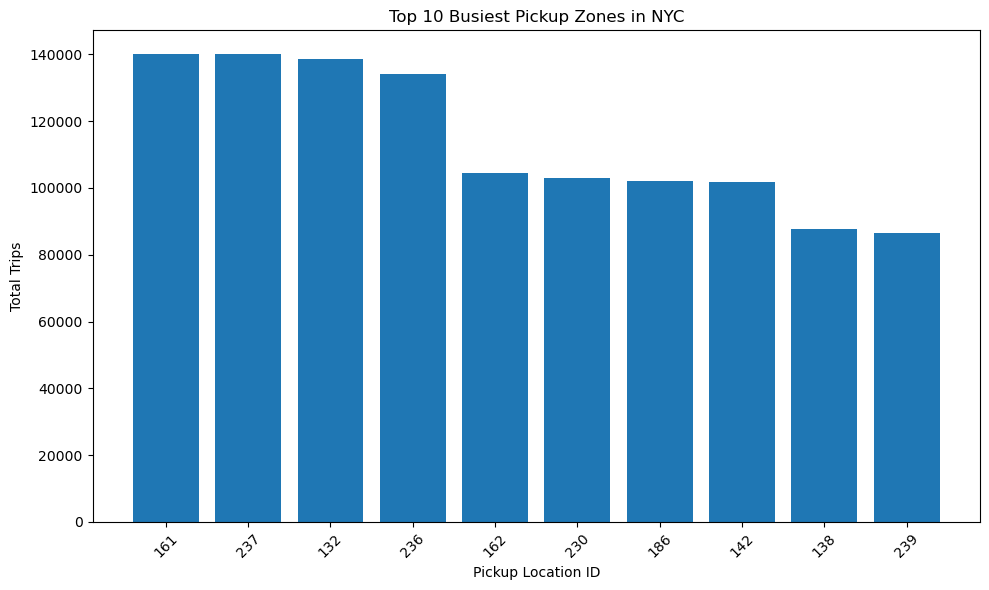

In [39]:
plt.figure(figsize=(10,6))
plt.bar(pandas_df["PULocationID"].astype(str), pandas_df["Total_trips"])
plt.xlabel("Pickup Location ID")
plt.ylabel("Total Trips")
plt.title("Top 10 Busiest Pickup Zones in NYC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


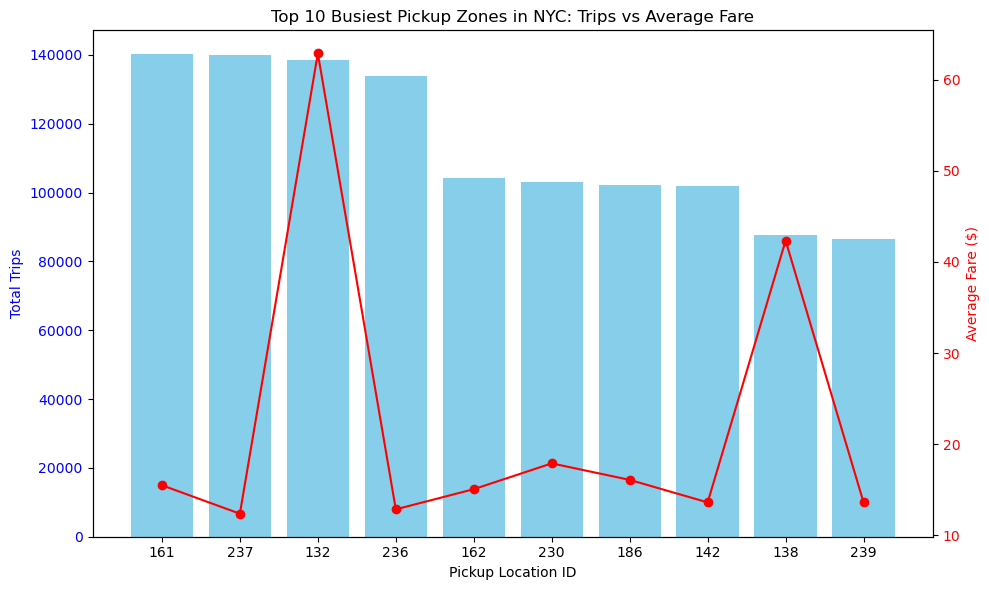

In [40]:
import matplotlib.pyplot as plt

# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Left Y-axis (Total Trips as bars)
ax1.bar(pandas_df["PULocationID"].astype(str),
        pandas_df["Total_trips"],
        color='skyblue',
        label='Total Trips')

ax1.set_xlabel("Pickup Location ID")
ax1.set_ylabel("Total Trips", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# --- Right Y-axis (Average Fare as line)
ax2 = ax1.twinx()  # creates a second axis sharing the same x-axis
ax2.plot(pandas_df["PULocationID"].astype(str),
         pandas_df["Avg_fair"],
         color='red',
         marker='o',
         label='Average Fare')

ax2.set_ylabel("Average Fare ($)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# --- Title & Styling
plt.title("Top 10 Busiest Pickup Zones in NYC: Trips vs Average Fare")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [41]:
# creating a variable to use in pandas 
result_df1 = spark.sql('''
 Select
       pickup_hour ,
       count(pickup_hour) as Total_trips,
       avg(fare_amount) as Avg_fair
from nyc_taxi
group by pickup_hour
order by Total_trips desc 
limit 10''')

In [42]:
pandas_df1= result_df1.toPandas()

In [43]:
pandas_df1.columns

Index(['pickup_hour', 'Total_trips', 'Avg_fair'], dtype='object')

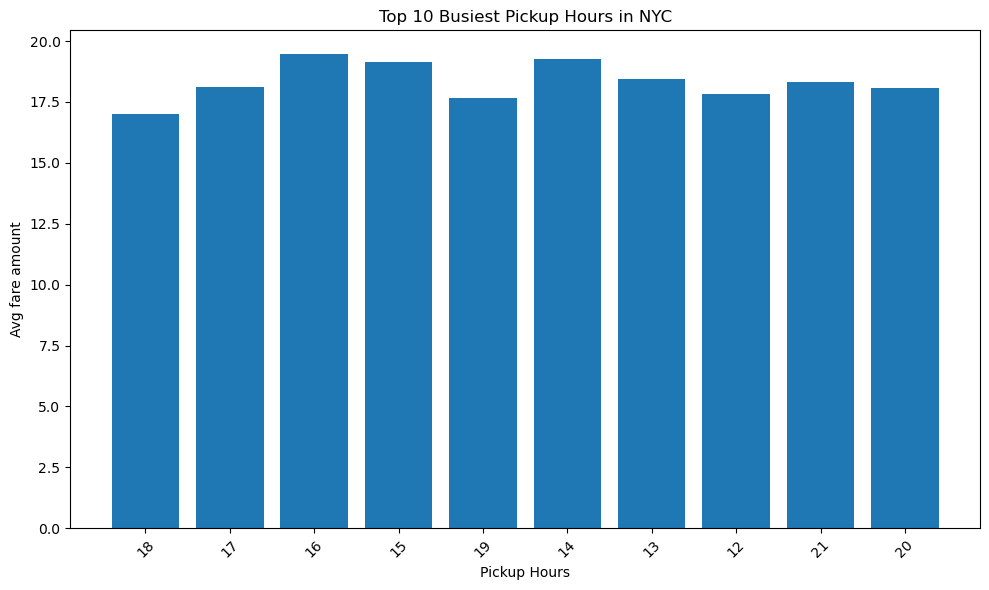

In [44]:
# Ploting Busiest Pickup Hours
plt.figure(figsize= (10,6))
plt.bar(pandas_df1["pickup_hour"].astype(str),pandas_df1["Avg_fair"])
plt.xlabel("Pickup Hours")
plt.ylabel("Avg fare amount")
plt.title("Top 10 Busiest Pickup Hours in NYC")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [45]:
## creating variable to use in pandas
result_df2 = spark.sql('''
           Select 
                 pickup_of_the_week, 
                 count(*) as Total_trips ,
                 round(avg(fare_amount),2) as avg_fair
            from nyc_taxi
            group by pickup_of_the_week
            order by pickup_of_the_week desc
            ''')

In [46]:
pandas_df2 = result_df2.toPandas()

In [47]:
pandas_df2.columns

Index(['pickup_of_the_week', 'Total_trips', 'avg_fair'], dtype='object')

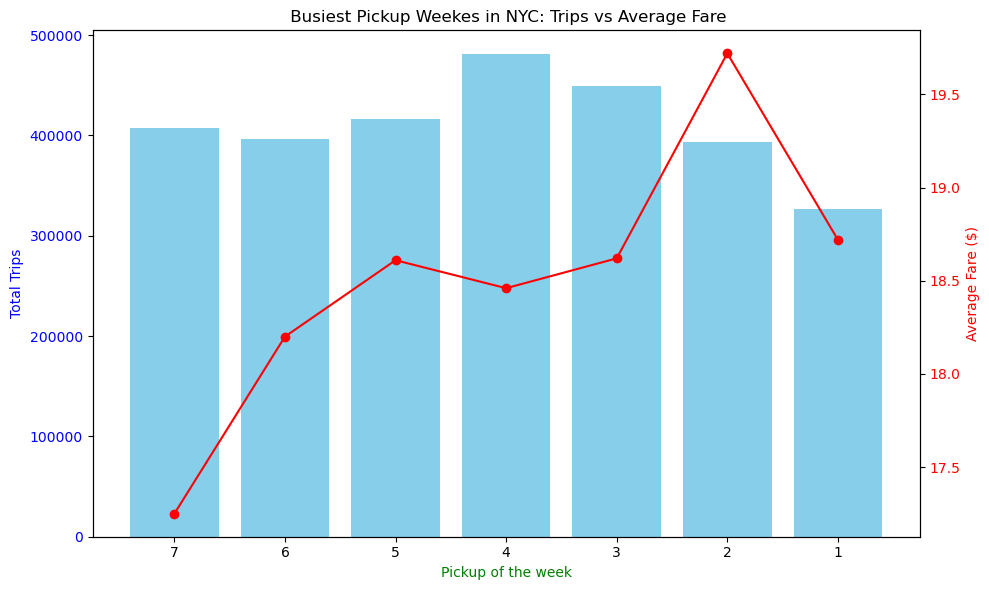

In [48]:
# Bar plot for weekly pickup 
# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(10,6))

# --- Left Y-axis (Total Trips as bars)
ax1.bar(pandas_df2["pickup_of_the_week"].astype(str),
        pandas_df2["Total_trips"],
        color='skyblue',
        label='Total Trips')

ax1.set_xlabel("Pickup of the week", color = 'Green')
ax1.set_ylabel("Total Trips", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# --- Right Y-axis (Average Fare as line)
ax2 = ax1.twinx()  # creates a second axis sharing the same x-axis
ax2.plot(pandas_df2["pickup_of_the_week"].astype(str),
         pandas_df2["avg_fair"],
         color='red',
         marker='o',
         label='Average Fare')

ax2.set_ylabel("Average Fare ($)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# --- Title & Styling
plt.title(" Busiest Pickup Weekes in NYC: Trips vs Average Fare")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 # 🧠 Data Insights Summary


#### 🚕 1. Trip Patterns by Hour

<ul style="font-size:12px;">
<li>The busiest hours for NYC taxi pickups are typically evening hours (6 PM – 9 PM).</li>
<li>This suggests peak demand during commuting and leisure times.</li>
</ul>

#### 💵 2. Fare Analysis

<ul style="font-size:12px;">
<li>Average fares are slightly higher during weekdays, likely due to business travel.</li>
<li>Weekend fares tend to be lower on average, but total trips remain steady.</li>
<li>Certain zones (especially near airports and midtown) show higher average fares due to longer trip distances.</li>
</ul>

#### 📍 3. Busiest Pickup Zones

<ul style="font-size:12px;">
<li>The most frequent pickup zones (e.g., PULocationID 132, 237) represent NYC hotspots such as airports and downtown areas.</li>
<li>These zones handle the highest number of rides and contribute significantly to total revenue.</li>
</ul>

#### ⏱ 4. Trip Duration and Speed

<ul style="font-size:12px;">
<li>The average trip duration and speed indicate typical NYC congestion levels — lower speeds during rush hours and central zones.</li>
<li>Speed variations can help identify traffic bottlenecks and potential optimization areas for drivers.</li>
</ul>

#### 📊 5. Overall Insights

<ul style="font-size:12px;">
<li>Evening trips are most common, weekday fares are highest, and airport zones dominate in both frequency and value.</li>
<li>These findings can guide driver allocation, pricing strategies, and city traffic planning.</li>
</ul>